In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD
import math

In [2]:
# Import the dataset
Google = yf.Ticker('GOOGL')
dataset = Google.history(period='1d', start='2010-01-01', end='2023-01-01')
dataset.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], inplace=True)

In [3]:
dataset

,Close
Date,
2010-01-04 00:00:00-05:00,15.684434
2010-01-05 00:00:00-05:00,15.615365
2010-01-06 00:00:00-05:00,15.221722
2010-01-07 00:00:00-05:00,14.867367
2010-01-08 00:00:00-05:00,15.065566
...,...
2022-12-23 00:00:00-05:00,89.230003
2022-12-27 00:00:00-05:00,87.389999
2022-12-28 00:00:00-05:00,86.019997


In [4]:

# Function to assist
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real Google Stock Price')
    plt.plot(predicted, color='blue', label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [5]:
# Extracting relevant data for training and testing
training_set = dataset[:'2020'].iloc[:, 0:1].values
test_set = dataset['2021':].iloc[:, 0:1].values


In [6]:
print(training_set.size)
print(test_set.size)

2769
503


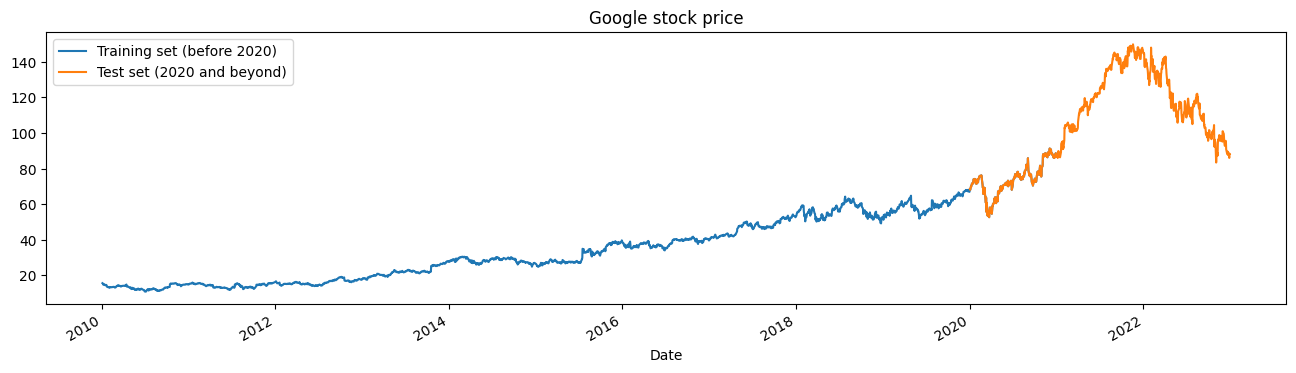

In [7]:
# Visualizing the dataset
dataset['Close'][:'2020'].plot(figsize=(16, 4), legend=True)
dataset['Close']['2020':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (before 2020)', 'Test set (2020 and beyond)'])
plt.title('Google stock price')
plt.show()


In [8]:
# Scaling the Training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:

# Creating input sequences for LSTM
X_train = []
y_train = []

for i in range(60, training_set.size):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [10]:
X_train.shape

(2709, 60, 1)

In [11]:
# Model architecture
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressor.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [12]:
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=150, verbose=0)

In [13]:
# Preparing the test set
dataset_total = pd.concat((dataset["Close"][:'2020'], dataset["Close"]['2021':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

print(inputs.shape[0])

563


In [14]:
X_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
# Predicting the stock prices
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


16/16 [==============================] - 4s 81ms/step


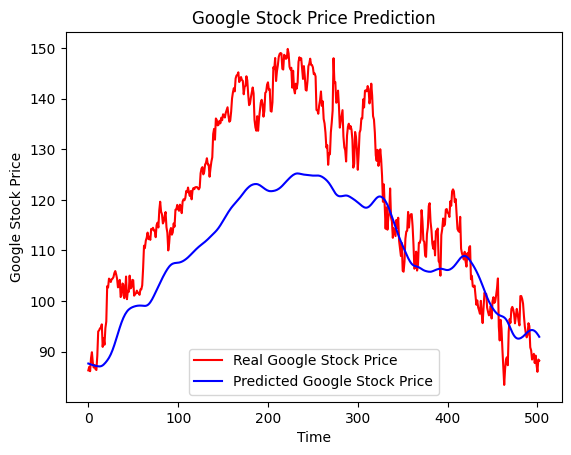

In [16]:
# Visualizing the results
plot_predictions(test_set, predicted_stock_price)


In [17]:
# Evaluating the model
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 13.162671503072128.
